In [19]:
import matplotlib.pyplot as plt
import glob
import os
import json
import numpy as np
import pandas as pd
from utils import load_m4_data
from transformation import Transformation

plt.rcParams["figure.figsize"] = (21, 10)
plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.handlelength"] = 2

In [20]:
# datasets = load_m4_data(min_length=1000, max_length=1500, n_set=64, freq='Daily')
# for name, series in datasets.items():
#     plt.plot(series)
#     plt.title(name)
#     plt.show()

In [21]:
df = pd.read_excel('./Dataset/M3c.xls', sheet_name='M3Month')
df.set_index(['Series'], inplace=True)
cate = pd.DataFrame(df.loc[:, 'Category'])

In [22]:
bad = ['D173', 'D50', 'D56', 'D86', 'D48', 'D49']
bad = []

def load_json(base_dir='./json_data', target_file=None):
    datas = []
    if not target_file:
        filepath = '/'.join([base_dir, '*.json'])
        target_file = max(glob.glob(filepath), key = os.path.getctime)
    print(target_file)
    with open(target_file, 'r') as file:
        for line in file.readlines():
            data = json.loads(line)
            if data['name'] in bad:
                continue
            datas.append(data)

    return datas

In [23]:
# datas = load_json(target_file='./json_data/m3_96_series.json')
# datas = load_json(target_file='./json_data/m3_48_log.json')
# datas = load_json(target_file='./json_data/m4_55_log_tmp.json')

# datas = load_json(target_file='./json_data/results_1657795470.json') ## m3 print log return prediction
# datas = load_json(target_file='./json_data/total_m3.json')
# datas = load_json(target_file='./json_data/test_gru_naive.json')
# datas = load_json(target_file='./json_data/m3_100_log.json')
# datas = load_json(target_file='./json_data/test_m3.json')
# datas = load_json(target_file='./json_data/m3_1043_detrend_v1_0722.json')
datas = load_json(target_file='./json_data/results_1658730134.json')

./json_data/results_1658730134.json


In [24]:
from utils import Performance_metrics
p = Performance_metrics()

count = 0
for data in datas:
    # if data['name'] != 'N1679':
    #     continue
    test = np.array(data['test_y']).ravel()
    for key in ['untransformed', 'transformed']:
        for model_name, model_val in data[key].items():
            # s = p.one_measure(scoring='symmetric_mean_absolute_percentage_error', true_y=test, pred_y=model_val['prediction'])
            # print(f'{model_name} {key}: {s}')
            if model_name == 'RandomForestRegressor':
                if data['untransformed'][model_name]['additional_info']['fitted_params']['n_estimators'] == 10:
                    count += 1
            else:
                continue
            # print(model_name, data['untransformed'][model_name]['additional_info']['fitted_params'])
    break

# from utils import Performance_metrics

# for data in datas:

#     test = np.array(data['test_y']).ravel()
#     for key in ['untransformed', 'transformed']:
#         for model_name, model_val in data[key].items():
#             print(f'{model_name} {key}')
#             p = Performance_metrics(true_y=test, predict_y=model_val['prediction'])
#             p.measuring(model_name=model_name, dataset_name=data['name'])
#             print('=='*20)
    

In [25]:


def plot_prediction(datas, model, dataset_name='', n_dataset=1, only_test=True):
    t = Transformation(datas)
    n_dataset_list = set()
    base = True
    df = pd.DataFrame()

    for data in datas:

        if model not in data['untransformed']:
            return

        if dataset_name and data['name'] != dataset_name:
            continue
        if len(n_dataset_list) < n_dataset:
            n_dataset_list.add(data['name'])
        if data['name'] not in n_dataset_list:
            continue

        train = np.array(data['train_y']).ravel()
        test = np.array(data['test_y']).ravel()

        if only_test:
            test_time_idx = range(len(test))[-200:]
        else:
            train_time_idx = range(len(train)+len(test))[:len(train)]
            test_time_idx = range(len(train)+len(test))[len(train):]

        if base:
            if not only_test:
                plt.plot(train_time_idx, train, linewidth=8, alpha=0.5, label='train data')
                plt.plot(train_time_idx, t.dwt_feature(train, wavelet=data['transformed'][model]['threshold'])[1], linewidth=8, alpha=0.5, label='train data (trans)')
            plt.plot(test_time_idx, test[-200:], label='test data', linewidth=8, alpha=0.5)
            plt.title(f'Series: {data["name"]}, Model: {model}')
            plt.legend()
            base = False

        pred = data['untransformed'][model]['prediction'][-200:]
        label = f"untransformed series, Lag: {data['untransformed'][model]['lags']}, SMAPE: {data['untransformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['untransformed'][model]['root_mean_squared_error']}"
        plt.plot(test_time_idx, pred, label=label, linewidth=5, alpha=0.5)
        
        pred = data['transformed'][model]['prediction'][-200:]
        label = f"threshold: {data['transformed'][model]['threshold']}, Lag: {data['transformed'][model]['lags']}, SMAPE: {data['transformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['transformed'][model]['root_mean_squared_error']}"
        plt.plot(test_time_idx, pred, label=label, linewidth=2.5, alpha=0.8)
        
        plt.legend()

    plt.tight_layout()
    plt.show()

In [26]:
def plot_log_prediction(datas, model, dataset_name='', n_dataset=1, only_test=True):
        n_dataset_list = set()
        base = True
        df = pd.DataFrame()

        for data in datas:
            if 'logr_train_y' not in data:
                return

            if model not in data['untransformed']:
                return

            if dataset_name and data['name'] != dataset_name:
                continue
            if len(n_dataset_list) < n_dataset:
                n_dataset_list.add(data['name'])
            if data['name'] not in n_dataset_list:
                continue

            train = np.array(data['logr_train_y']).ravel()
            test = np.array(data['logr_test_y']).ravel()

            if only_test:
                test_time_idx = range(len(test))[-200:]
            else:
                train_time_idx = range(len(train)+len(test))[:len(train)]
                test_time_idx = range(len(train)+len(test))[len(train):]

            if base:
                if not only_test:
                    plt.plot(train_time_idx, train, linewidth=8, alpha=0.5)
                plt.plot(test_time_idx, test[-200:], label='test data', linewidth=8, alpha=0.5)
                plt.title(f'[Log Return] Series: {data["name"]}, Model: {model}')
                plt.legend()
                base = False

            pred = np.array(data['untransformed'][model]['log_prediction'][-200:]).ravel()
            label = f"untransformed series, Lag: {data['untransformed'][model]['lags']}, SMAPE: {data['untransformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['untransformed'][model]['root_mean_squared_error']}"
            plt.plot(test_time_idx, pred, label=label, linewidth=5, alpha=0.5)
            
            pred = np.array(data['transformed'][model]['log_prediction'][-200:]).ravel()
            label = f"threshold: {data['transformed'][model]['threshold']}, Lag: {data['transformed'][model]['lags']}, SMAPE: {data['transformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['transformed'][model]['root_mean_squared_error']}"
            plt.plot(test_time_idx, pred, label=label, linewidth=2.5, alpha=0.8)
            
            plt.legend()


        plt.tight_layout()
        plt.show()

In [53]:
def smape_result():
    smape_df = pd.DataFrame()
    info = dict()
    d = ['N1679', 'N1680', 'N1681', 'N1682', 'N1683', 'N1684', 'N1685', 'N1686',
       'N1687', 'N1688', 'N1689', 'N1690', 'N1691', 'N1692', 'N1693', 'N1694',
       'N1695', 'N1696', 'N1697', 'N1698', 'N1699', 'N1700', 'N1701', 'N1702',
       'N1703', 'N1704', 'N1705', 'N1706', 'N1707', 'N1708', 'N1709', 'N1710',
       'N1711', 'N1712', 'N1713', 'N1714', 'N1715', 'N1716', 'N1717', 'N1718',
       'N1719', 'N1720', 'N1721', 'N1722', 'N1723', 'N1724', 'N1725', 'N1726',]

    #    ['D1661', 'D1662', 'D1663', 'D1664', 'D1665', 'D1666', 'D1667', 'D1668',
    #    'D1669', 'D1670', 'D201', 'D202', 'D203', 'D204', 'D205', 'D206',
    #    'D207', 'D208', 'D209', 'D210', 'D2121', 'D2122', 'D2123', 'D2124',
    #    'D2125', 'D2126', 'D2127', 'D2128', 'D2129', 'D2130', 'D3621', 'D3622',
    #    'D3623', 'D3624', 'D3625', 'D3626', 'D3627', 'D3628', 'D3629', 'D3630',
    #    'D51', 'D52', 'D53', 'D54', 'D55', 'D56', 'D57', 'D58', 'D59', 'D60']
    for data in datas:
        dataset_name = data['name']
        # if dataset_name not in d:
        #     continue
        # if dataset_name not in ['D51', 'D52', 'D53', 'D54', 'D55', 'D56', 'D57', 'D58', 'D59', 'D60']:
        #     continue
        for key in ['untransformed', 'transformed']:
            try:
                for model_name, model_val in data[key].items():
                    if model_name not in info:
                        info[model_name] = dict()
                    info[model_name][key] = model_val['symmetric_mean_absolute_percentage_error']
                    # info[model_name][key] = model_val['root_mean_squared_error']
            except:
                print(dataset_name)
                continue
        reform = {(outerKey, innerKey): values for outerKey, innerDict in info.items() for innerKey, values in dict(innerDict).items()}
        # print(reform)
        df = pd.DataFrame(reform, index=[dataset_name])
        # df.columns = pd.MultiIndex.from_product([[dataset_name], df.columns])
        # return df
        # df = pd.DataFrame.from_dict(info, orient='columns')
        # df.columns = pd.MultiIndex.from_product([[dataset_name], df.columns])
        # return df
        smape_df = pd.concat([smape_df, df], axis=0)
    # smape_df.drop(index=['D173', 'D50', 'D56', 'D86', 'D48'], inplace=True)
    smape_df.loc[('Total',)] = smape_df.sum()
    return smape_df.sort_index()

smape_df = smape_result()

ccate = pd.concat([smape_df, cate], axis=1)
ccate.dropna(how='any', inplace=True)

# print(smape_df.index)
smape_df.iloc[-1:,]
smape_df

ccate.groupby('Category').mean()
smape_df

ElasticNet                 LinearSVR             KNeighborsRegressor  \
      untransformed transformed untransformed transformed       untransformed   
N1680         0.291       0.395         0.463       0.477               0.328   
N1683         0.089       0.098         0.097       0.098               0.087   
N1689         0.240       0.281         0.295       0.315               0.242   
N1690         0.364       0.412         0.478       0.481               0.333   
N1705         0.927       0.967         1.233       1.203               1.000   
...             ...         ...           ...         ...                 ...   
N2728         0.006       0.009         0.007       0.009               0.013   
N2736         0.148       0.151         0.107       0.170               0.151   
N2742         0.098       0.090         0.092       0.112               0.092   
N2777         0.003       0.003         0.004       0.004               0.005   
Total        19.515      20.983        26.641      25.656              21.710   

                  RandomForestRegressor              MLPRegressor              \
      transformed         untransformed transformed untransformed transformed   
N1680       0.316                 0.471       0.405         0.277       0.296   
N1683       0.074                 0.161       0.142         0.097       0.123   
N1689       0.225                 0.352       0.370         0.375       0.332   
N1690       0.375                 0.527       0.399         0.450       0.318   
N1705       0.920                 0.983       1.013         1.125       1.325   
...           ...                   ...         ...           ...         ...   
N2728       0.015                 0.011       0.012         0.010       0.012   
N2736       0.155                 0.211       0.172         0.141       0.199   
N2742       0.086                 0.129       0.087         0.083       0.127   
N2777       0.006                 0.005       0.008         0.010       0.013   
Total      21.372                24.961      22.987        27.066      27.260   

            AutoETS             NaiveForecaster              
      untransformed transformed   untransformed transformed  
N1680         0.357       0.363           0.422       0.422  
N1683         0.128       0.068           0.105       0.102  
N1689         0.252       0.262           0.288       0.288  
N1690         0.342       0.419           0.471       0.426  
N1705         1.063       1.075           0.856       1.075  
...             ...         ...             ...         ...  
N2728         0.010       0.009           0.012       0.012  
N2736         0.169       0.151           0.169       0.167  
N2742         0.088       0.098           0.089       0.090  
N2777         0.003       0.004           0.003       0.003  
Total        20.620      20.811          21.321      21.718  

[205 rows x 14 columns]

In [28]:
def ranking():
    ranking = dict()
    frac_best = dict()
    for data in datas:
        for key in ['untransformed', 'transformed']:
            tmp_rank = []
            if data['name'] == 'N1705':
                continue
            for model_name, model_val in data[key].items():
                if model_name not in ranking:
                    ranking[model_name] = dict()
                    frac_best[model_name] = dict()
                if key not in frac_best[model_name]:
                    ranking[model_name][key] = 0
                    frac_best[model_name][key] = 0
                tmp_rank.append((model_name, model_val['symmetric_mean_absolute_percentage_error']))
            rank = sorted(tmp_rank, key=lambda x: x[1])


            for rank_idx in range(len(rank)):
                model_name, _ = rank[rank_idx]
                ranking[model_name][key] += (rank_idx + 1)
                if rank_idx == 0:
                    frac_best[model_name][key] += 1

    df = pd.DataFrame.from_dict(ranking) / len(datas)
    frac_df = pd.DataFrame.from_dict(frac_best) / len(datas) * 100
    df.loc['mean'] = df.mean()
    frac_df.loc['mean'] = frac_df.mean()
    df.index = pd.MultiIndex.from_product([['RANK'], df.index])
    frac_df.index = pd.MultiIndex.from_product([['FRAC-BEST(%)'], frac_df.index])
    return pd.concat([df, frac_df], axis=0)

rf_df = ranking()

In [29]:
new_smape = dict()
smape_dict = smape_df.loc['Total'].to_dict()
for (model_name, key), smape in smape_dict.items():
    if model_name not in new_smape:
        new_smape[model_name] = dict()
    if key not in new_smape[model_name]:
        new_smape[model_name][key] = smape

tot_smape_df = pd.DataFrame(new_smape)
tot_smape_df.loc['total'] = tot_smape_df.sum()
tot_smape_df.index = pd.MultiIndex.from_product([['sMAPE'], tot_smape_df.index])

pd.concat([tot_smape_df, rf_df], axis=0)

ElasticNet  LinearSVR  KNeighborsRegressor  \
sMAPE        untransformed   19.515000  26.641000            21.710000   
             transformed     20.983000  25.656000            21.372000   
             total           40.498000  52.297000            43.082000   
RANK         untransformed    2.411765   4.833333             4.279412   
             transformed      2.696078   4.921569             3.843137   
             mean             2.553922   4.877451             4.061275   
FRAC-BEST(%) untransformed   33.333333   3.431373             9.803922   
             transformed     23.529412   4.411765            22.058824   
             mean            28.431373   3.921569            15.931373   

                            RandomForestRegressor  MLPRegressor    AutoETS  \
sMAPE        untransformed              24.961000     27.066000  20.620000   
             transformed                22.987000     27.260000  20.811000   
             total                      47.948000     54.326000  41.431000   
RANK         untransformed               5.191176      4.862745   2.519608   
             transformed                 4.965686      5.049020   2.651961   
             mean                        5.078431      4.955882   2.585784   
FRAC-BEST(%) untransformed               3.921569     10.784314  31.372549   
             transformed                 2.941176      7.843137  30.882353   
             mean                        3.431373      9.313725  31.127451   

                            NaiveForecaster  
sMAPE        untransformed        21.321000  
             transformed          21.718000  
             total                43.039000  
RANK         untransformed         3.764706  
             transformed           3.735294  
             mean                  3.750000  
FRAC-BEST(%) untransformed         6.862745  
             transformed           7.843137  
             mean                  7.352941

In [30]:
def cal_threshold():
    thresholds = dict()
    better_thresholds = dict()
    for data in datas:
        if data['name'] == 'N1705':
            continue
        key = 'transformed'
        for model_name, model_val in data[key].items():
            if model_name not in thresholds:
                thresholds[model_name] = dict()
                better_thresholds[model_name] = dict()
            if model_val['threshold'] not in thresholds[model_name]:
                thresholds[model_name][model_val['threshold']] = 0
                better_thresholds[model_name][model_val['threshold']] = 0

            thresholds[model_name][model_val['threshold']] += 1
            if model_val['symmetric_mean_absolute_percentage_error'] < data['untransformed'][model_name]['symmetric_mean_absolute_percentage_error']:
                better_thresholds[model_name][model_val['threshold']] += 1
        
    df = pd.DataFrame.from_dict(thresholds).sort_index().fillna(0).astype(int)
    df['Total'] = df.sum(axis=1)
    df.loc['Total'] = df.sum(axis=0)
    df.index = pd.MultiIndex.from_product([['Optimal Threshold'], df.index])

    better_df = pd.DataFrame.from_dict(better_thresholds).sort_index().fillna(0).astype('object')
    better_df.loc['Total(%)'] = better_df.sum(axis=0) / len(datas) * 100
    better_df['Total(%)'] = round(better_df.sum(axis=1) / df['Total'].values * 100)
    better_df.index = pd.MultiIndex.from_product([['Better than raw data'], better_df.index])
    return df.T, better_df.astype(int).T

df, better_df = cal_threshold()
df

Optimal Threshold                              
                                  coif2 coif3 db19 db20 db5 db6 Total
ElasticNet                            0    10   86  106   1   0   203
LinearSVR                             2     4   89  105   3   0   203
KNeighborsRegressor                   8    37   66   55  20  17   203
RandomForestRegressor                 5    23   79   81   8   7   203
MLPRegressor                          6    25   70   79  11  12   203
AutoETS                               1    16   95   90   0   1   203
NaiveForecaster                       0     7   84  110   2   0   203
Total                                22   122  569  626  45  37  1421

In [31]:
better_df.iloc[-1,-1] = np.nan
better_df

Better than raw data                                 
                                     coif2 coif3 db19 db20 db5 db6 Total(%)
ElasticNet                               0     4   22   37   1   0     31.0
LinearSVR                                0     1   52   56   1   0     53.0
KNeighborsRegressor                      4    20   45   35   8  10     59.0
RandomForestRegressor                    1    11   56   51   3   1     60.0
MLPRegressor                             3    12   31   42   5   5     48.0
AutoETS                                  1     1   31   28   0   0     29.0
NaiveForecaster                          0     2   38   36   0   0     37.0
Total(%)                                41    42   48   46  40  43      NaN

In [32]:
def cal_lag(index='lags'):
    lags = dict()
    for data in datas:
        if data['name'] == 'N1705':
            continue
        for key in ['untransformed', 'transformed']:
            for model_name, model_val in data[key].items():
                if model_name in ['AutoETS', 'NaiveForecaster']:
                    continue
                if model_name not in lags:
                    lags[model_name] = dict()
                if key not in lags[model_name]:
                    lags[model_name][key] = dict()
                if model_val[index] not in lags[model_name][key]:
                    lags[model_name][key][model_val[index]] = 0

                lags[model_name][key][model_val[index]] += 1
    reform = {(outerKey, innerKey): values for outerKey, innerDict in lags.items() for innerKey, values in dict(innerDict).items()}
    df = pd.DataFrame(reform).sort_index().fillna(0).astype(int)
    # df.drop(index='AutoETS', inplace=True)
    df['Total'] = df.sum(axis=1)
    df.index = pd.MultiIndex.from_product([['Lag'], df.index])
    return df.T

df = cal_lag(index='lags')
df

Lag      
                                      1     12
ElasticNet            untransformed  109    94
                      transformed    178    25
LinearSVR             untransformed   61   142
                      transformed    145    58
KNeighborsRegressor   untransformed   82   121
                      transformed     74   129
RandomForestRegressor untransformed   76   127
                      transformed     87   116
MLPRegressor          untransformed   64   139
                      transformed     52   151
Total                                928  1102

In [33]:
df = pd.concat([list(df.groupby(level=1))[1][1].sum(), list(df.groupby(level=1))[2][1].sum()], axis=1).T.astype(int)
df.index = ['transformed(sum)', 'untransformed(sum)']
df

Lag     
                     1    12
transformed(sum)    536  479
untransformed(sum)  392  623

In [34]:
plot_prediction(datas, model='GRU', only_test=False)

In [35]:
plot_log_prediction(datas, model='GRU')

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


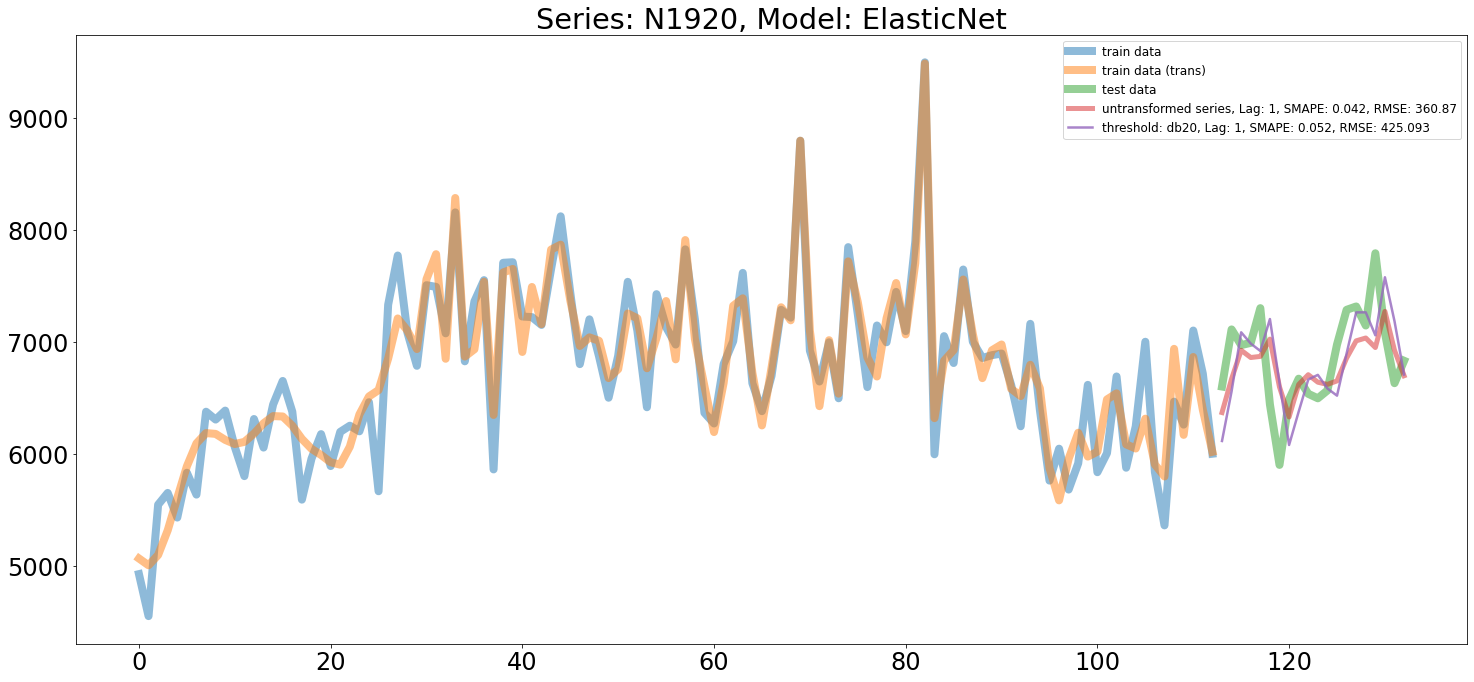

In [36]:
plot_prediction(datas, model='ElasticNet', only_test=False)

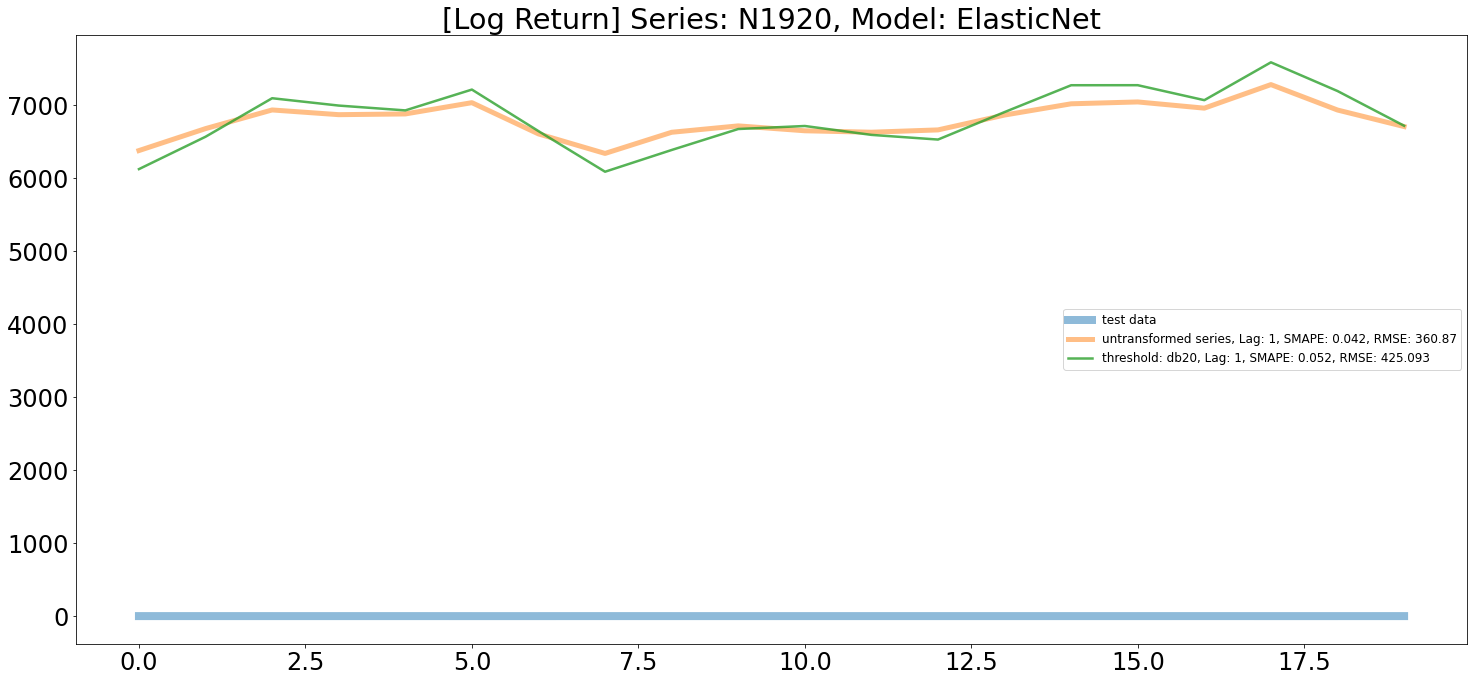

In [37]:
plot_log_prediction(datas, model='ElasticNet')

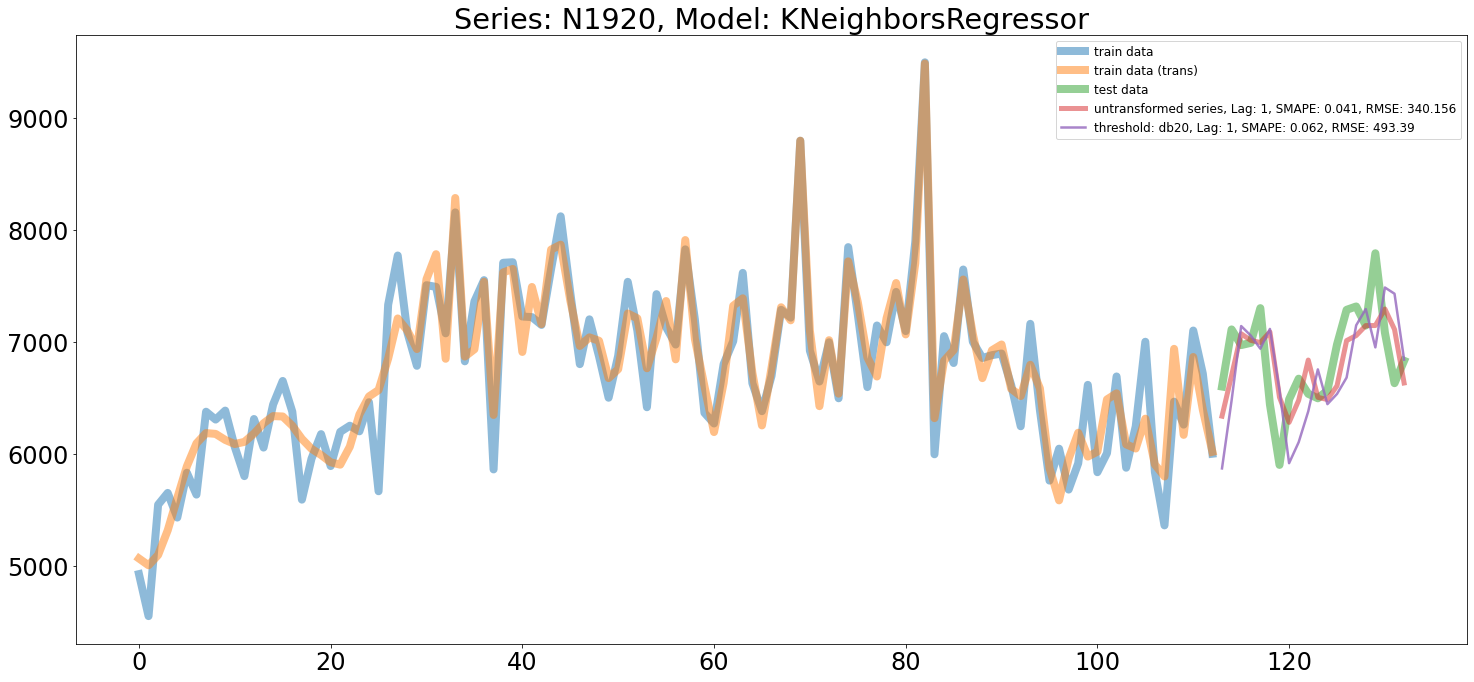

In [38]:
plot_prediction(datas, model='KNeighborsRegressor', only_test=False)

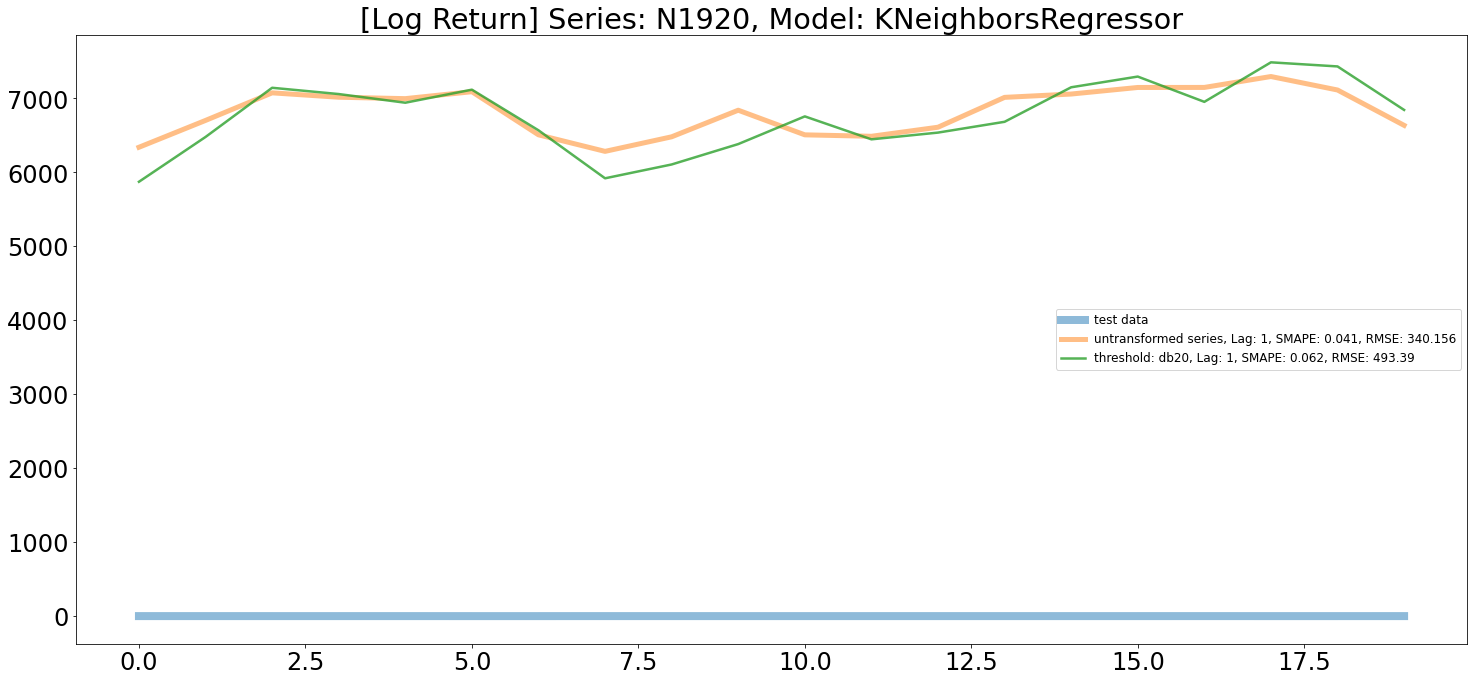

In [39]:
plot_log_prediction(datas, model='KNeighborsRegressor')

/Users/nick/opt/anaconda3/envs/afe/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


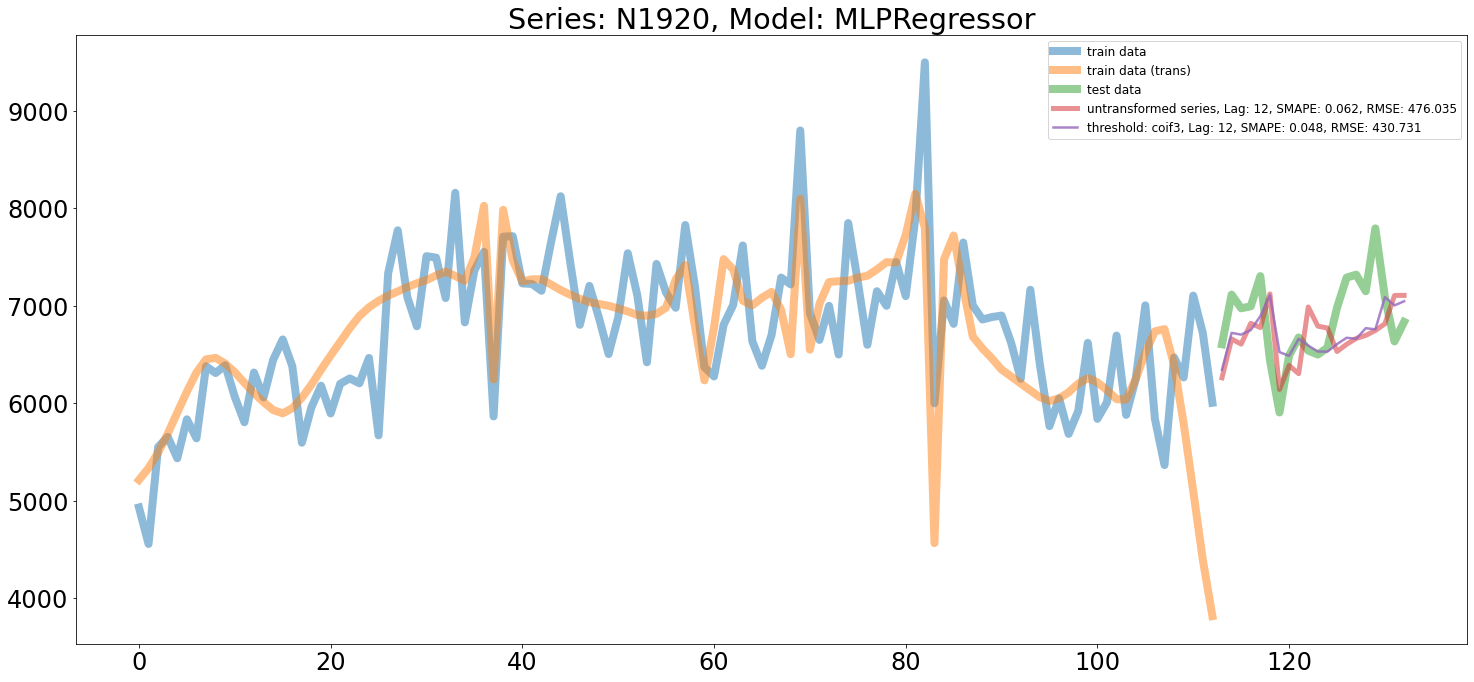

In [40]:
plot_prediction(datas, model='MLPRegressor', only_test=False)

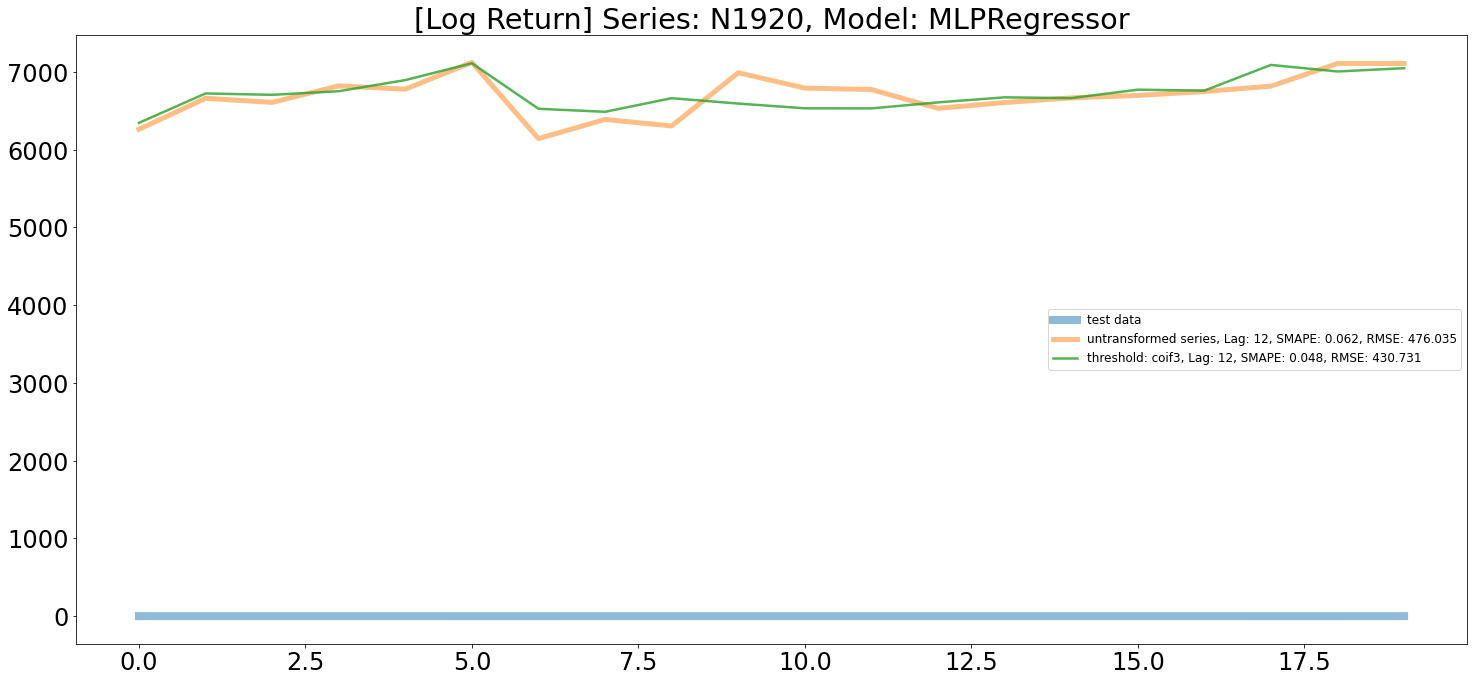

In [41]:
plot_log_prediction(datas, model='MLPRegressor')

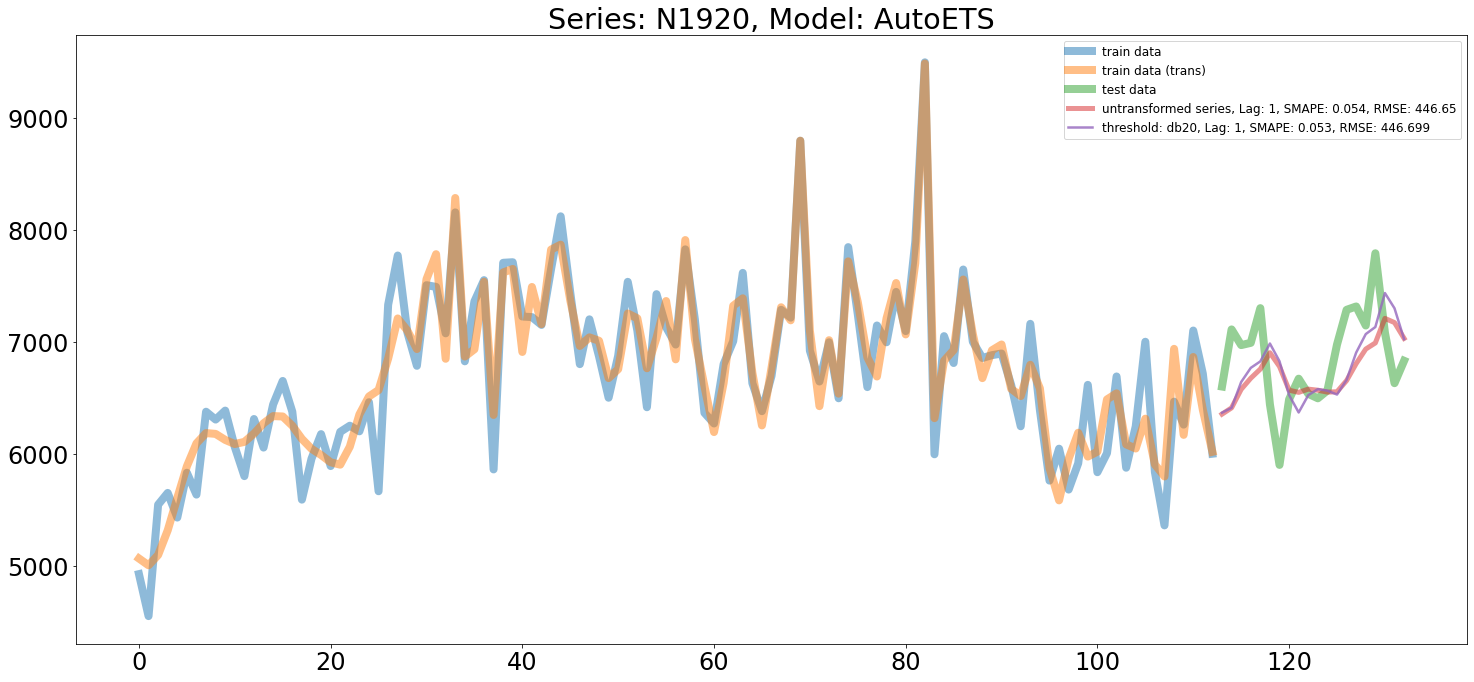

In [42]:
plot_prediction(datas, model='AutoETS', only_test=False)

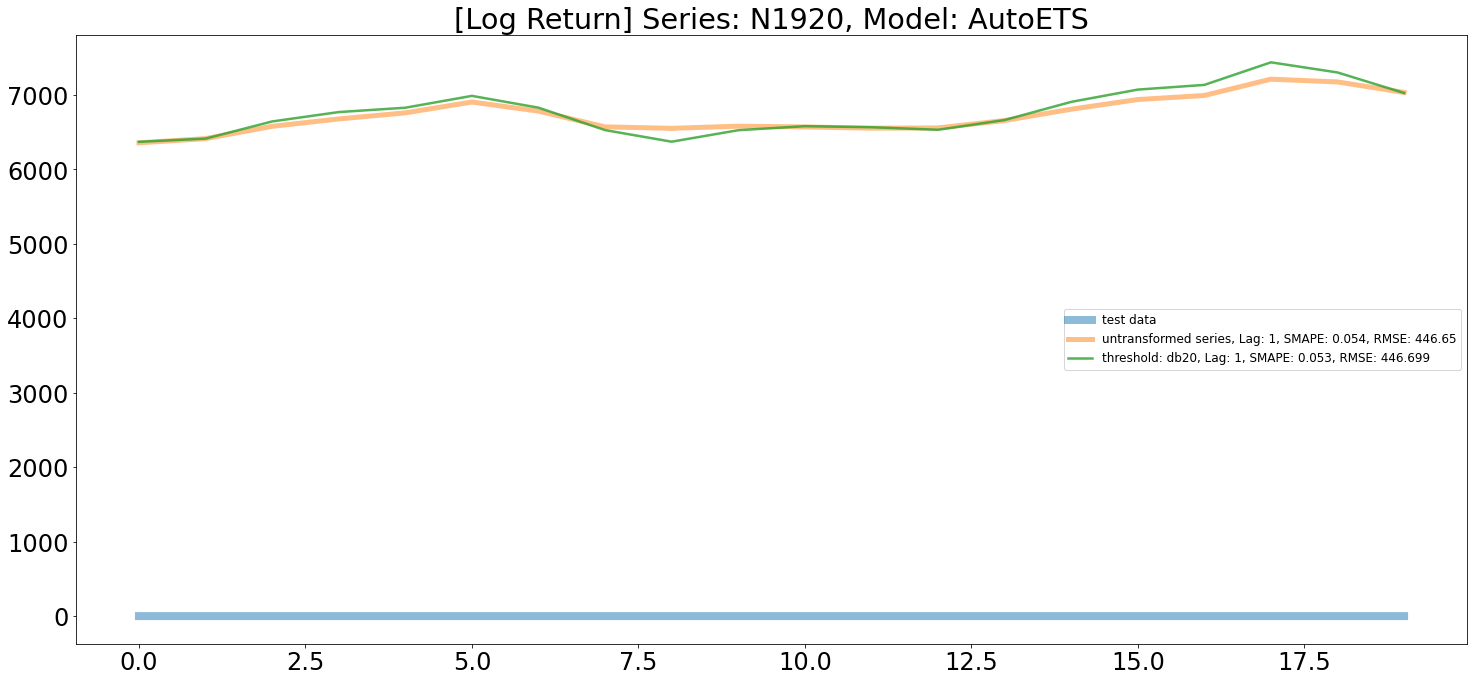

In [43]:
plot_log_prediction(datas, model='AutoETS')

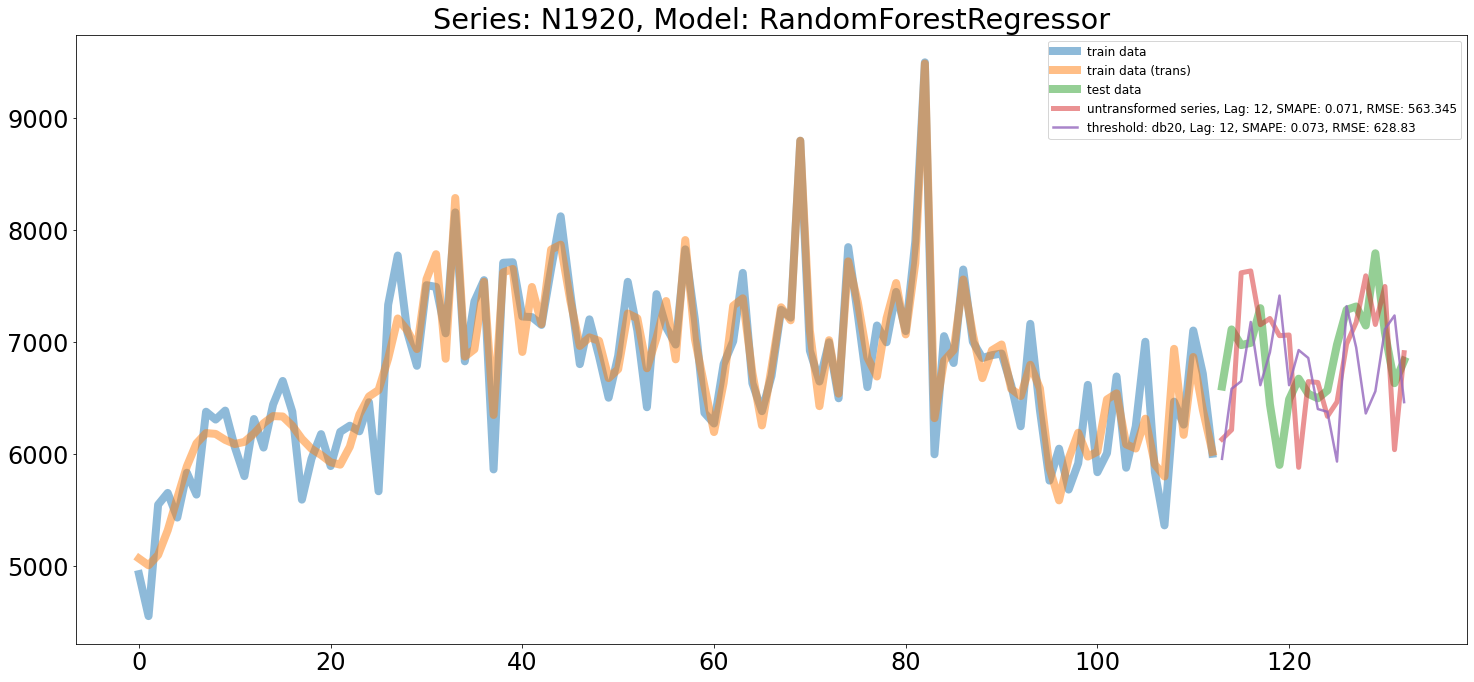

In [44]:
plot_prediction(datas, model='RandomForestRegressor', only_test=False)

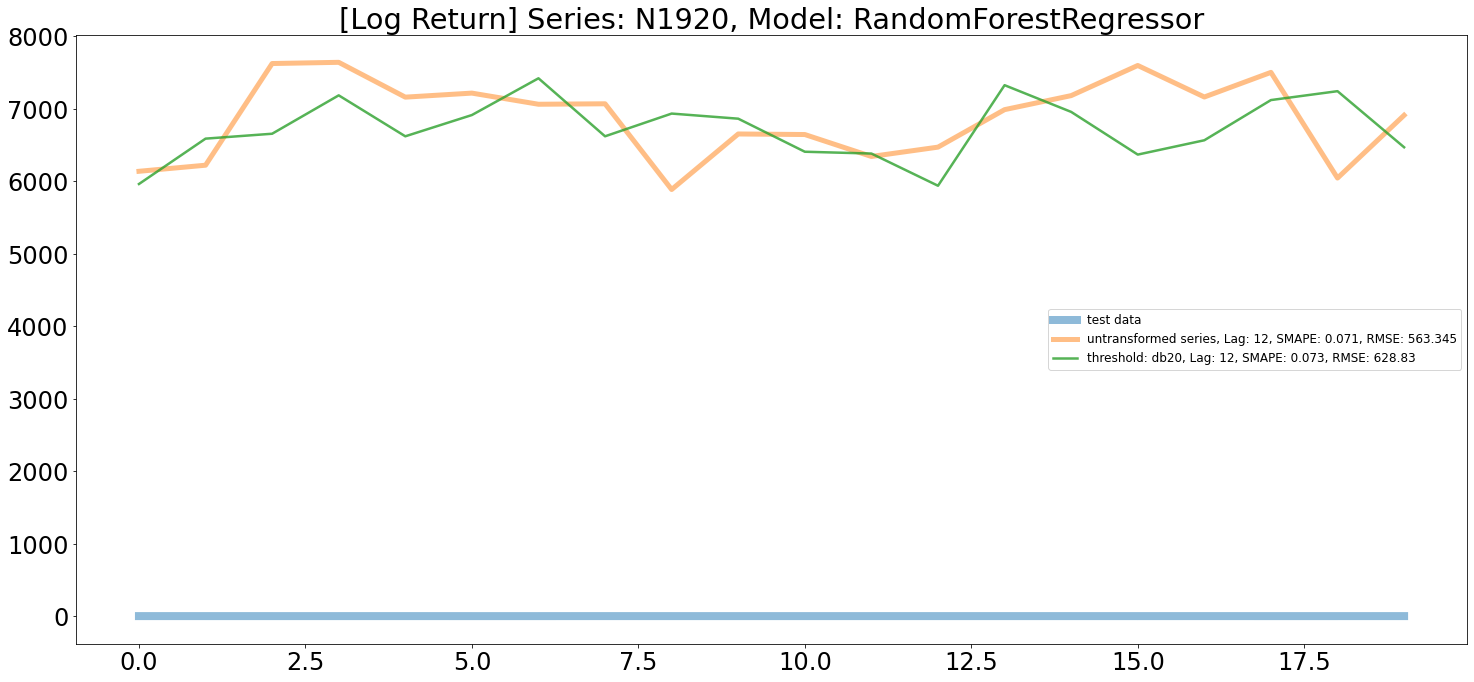

In [45]:
plot_log_prediction(datas, model='RandomForestRegressor')

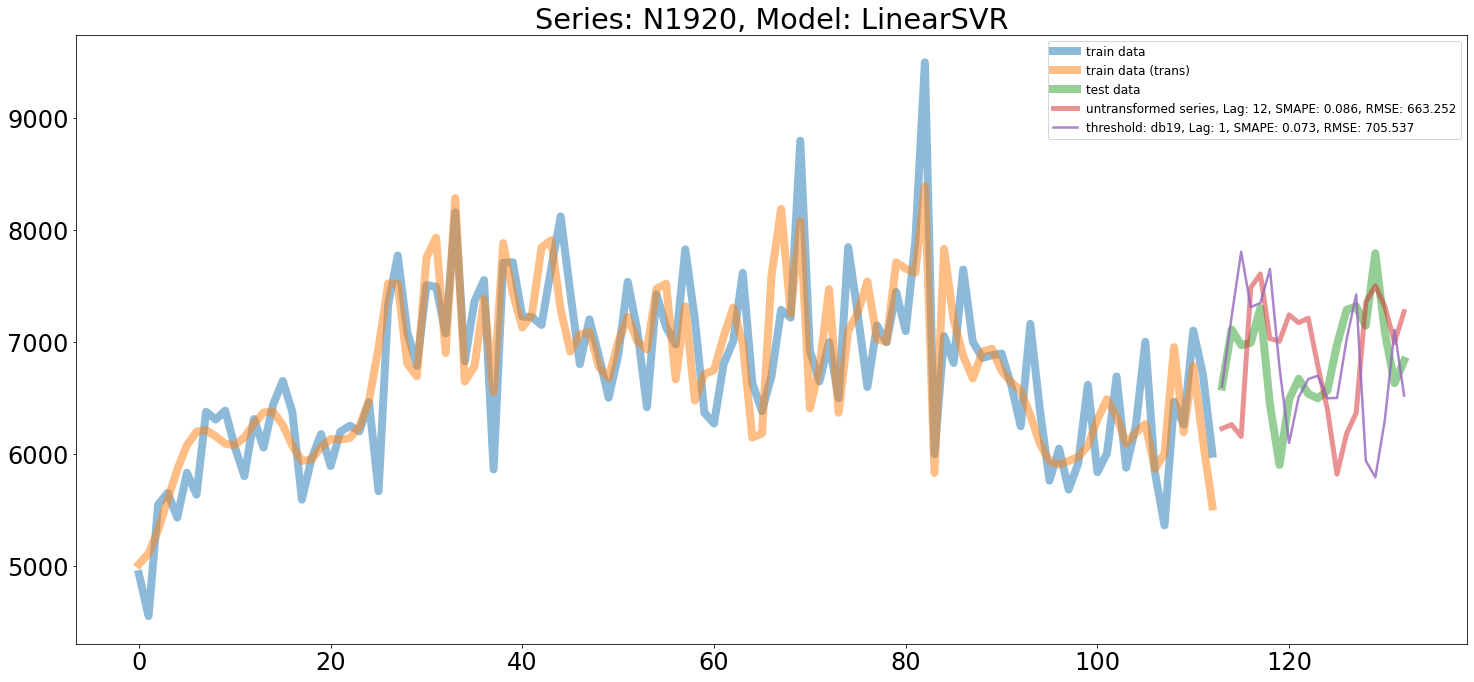

In [46]:
plot_prediction(datas, model='LinearSVR', only_test=False)

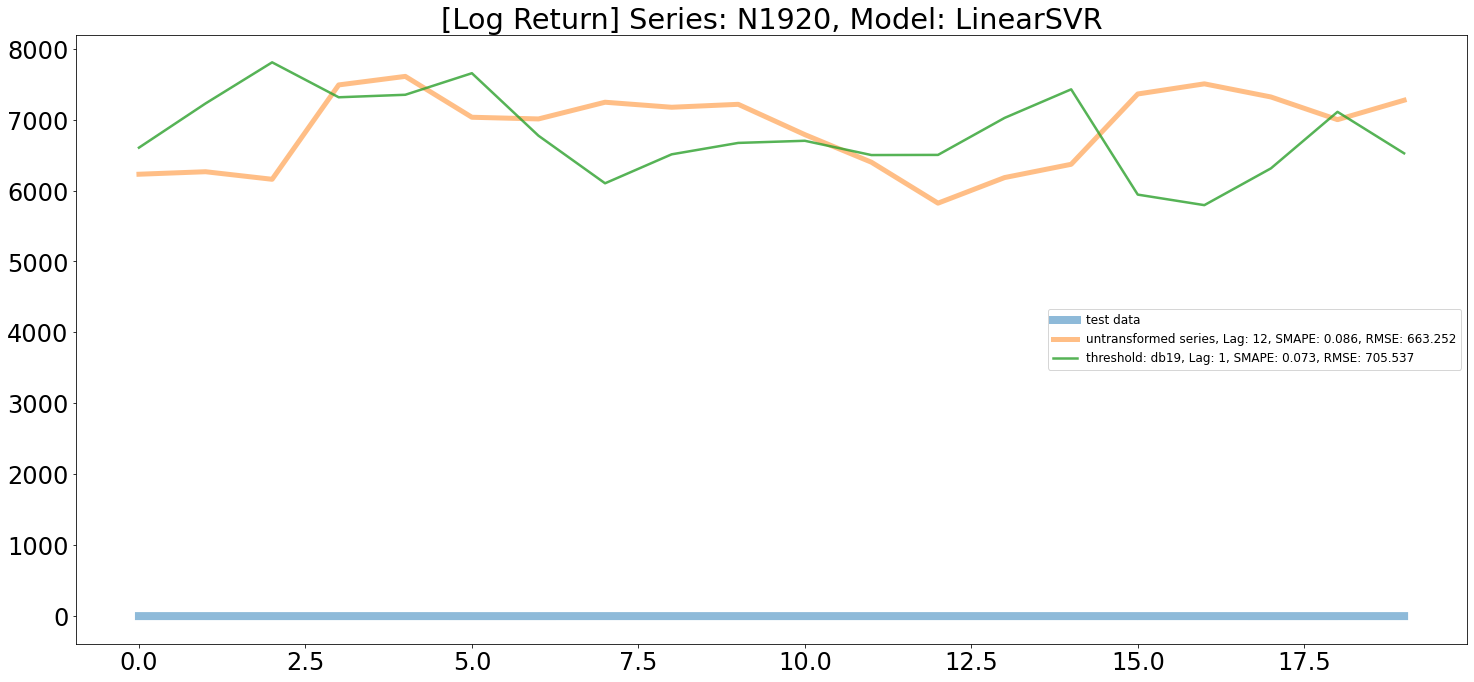

In [47]:
plot_log_prediction(datas, model='LinearSVR')

In [48]:
plot_prediction(datas, model='LSTM')

In [49]:
plot_log_prediction(datas, model='LSTM')

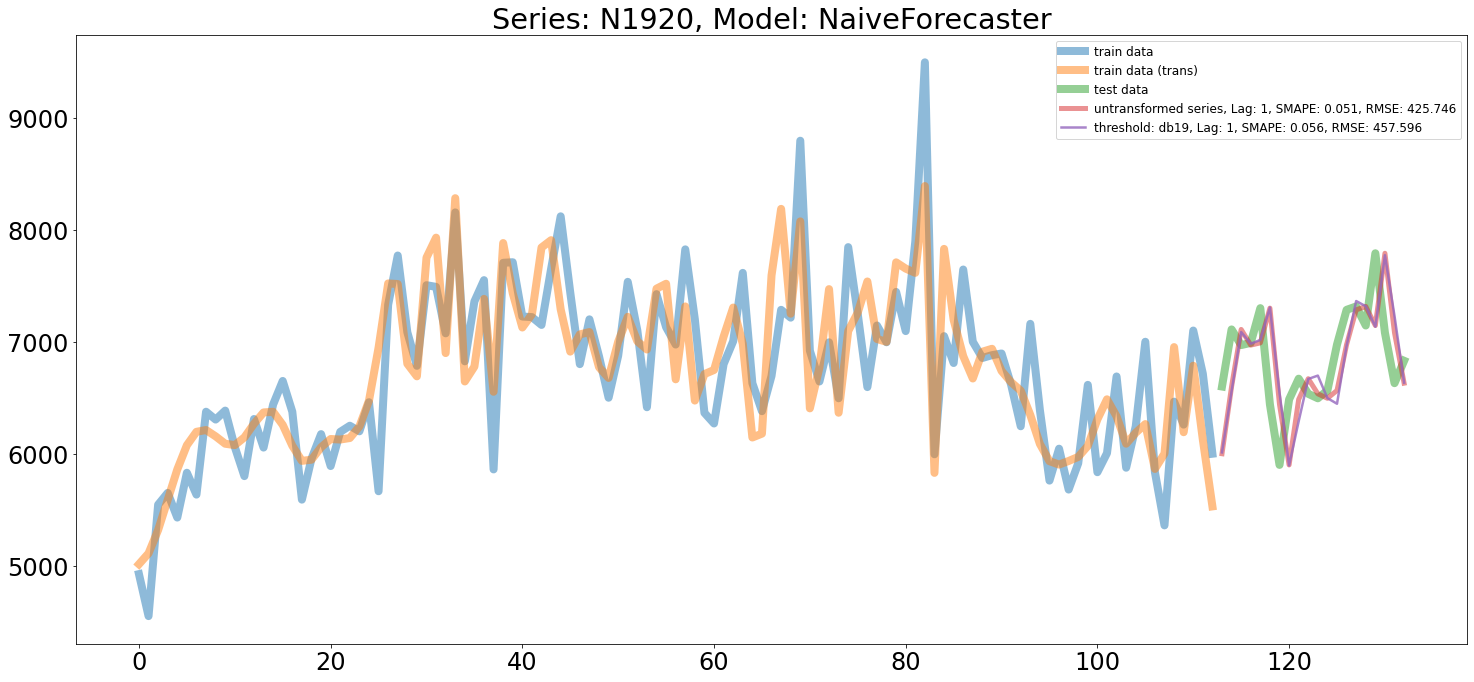

In [50]:
plot_prediction(datas, model='NaiveForecaster', only_test=False)

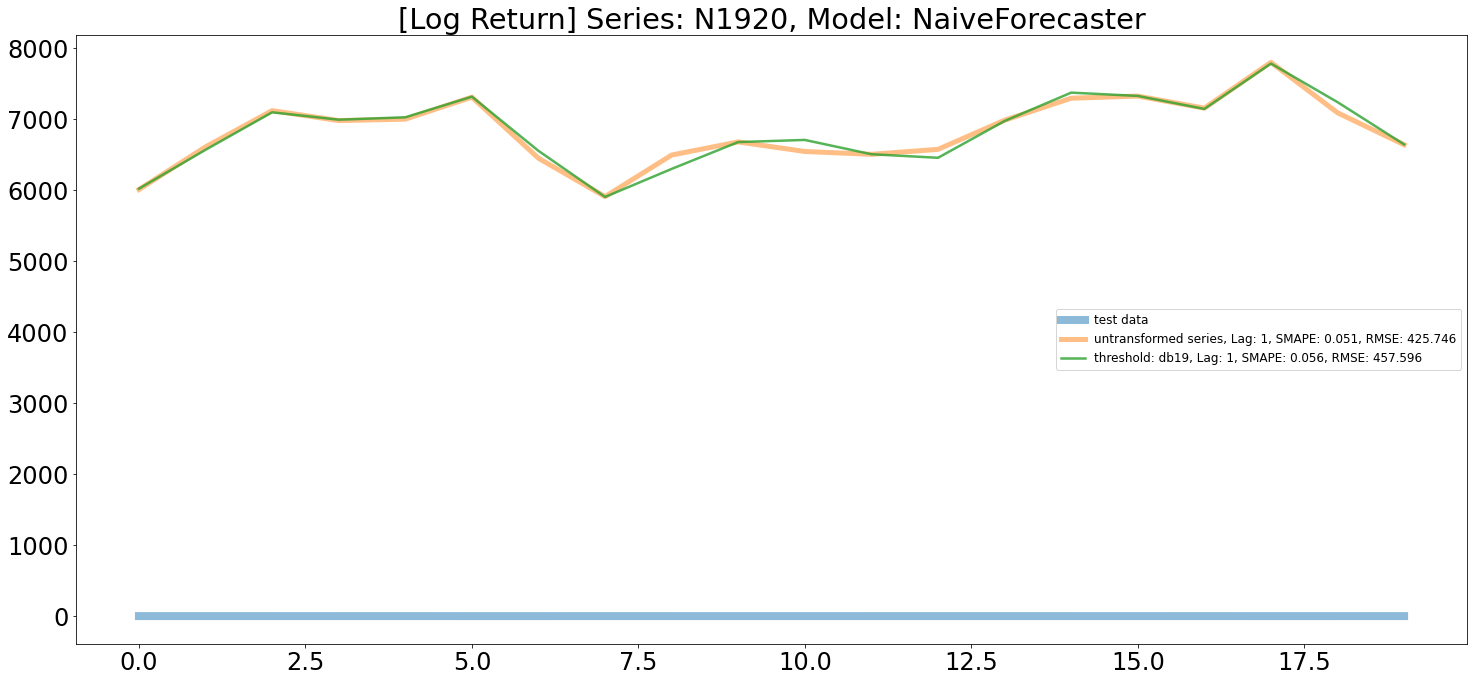

In [51]:
plot_log_prediction(datas, model='NaiveForecaster')

['ElasticNet(u)', 'ElasticNet(t)', 'LinearSVR(u)', 'LinearSVR(t)', 'KNeighborsRegressor(u)', 'KNeighborsRegressor(t)', 'RandomForestRegressor(u)', 'RandomForestRegressor(t)', 'MLPRegressor(u)', 'MLPRegressor(t)', 'AutoETS(u)', 'AutoETS(t)', 'NaiveForecaster(u)', 'NaiveForecaster(t)']


Text(0, 0.5, 'sMAPE')

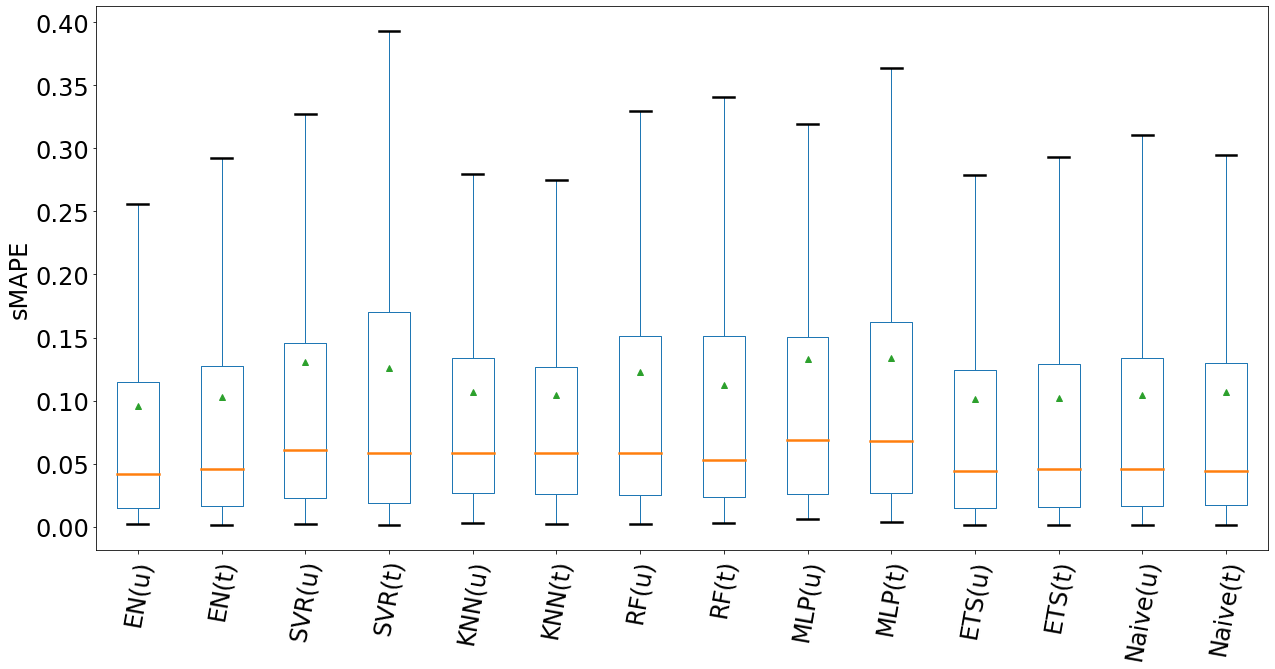

In [52]:


# smape_df.columns = [f'{m}({t[0]})' for m, t in smape_df.columns]
print([f'{m}({t[0]})' for m, t in smape_df.columns])
smape_df.columns = ['EN(u)', 'EN(t)', 'SVR(u)', 'SVR(t)', 'KNN(u)', 'KNN(t)', 'RF(u)', 'RF(t)', 'MLP(u)', 'MLP(t)', 'ETS(u)', 'ETS(t)', 'Naive(u)', 'Naive(t)']
# smape_df.columns = ['GRU(u)', 'GRU(t)', 'ETS(u)', 'ETS(t)', 'Naive(u)', 'Naive(t)']
# smape_df.columns = ['EN(u)', 'EN(t)', 'MLP(u)', 'MLP(t)', 'GRU(u)', 'GRU(t)', 'ETS(u)', 'ETS(t)']
smape_df.iloc[:-1,].boxplot(grid=False, showfliers=False, showmeans=True, rot=80, medianprops=dict(linewidth=2.5), capprops=dict(linewidth=2.5))
plt.ylabel('sMAPE')